In [16]:
gdf = gpd.read_file("datasets/shapefiles/SimplyAnalytics_Shapefiles_2024-03-25_15_51_20_06bb5972b23ee930944d21c6a8f8c132.shp")
gdf


,spatial_id,name,VALUE0,VALUE1,VALUE2,VALUE3,VALUE4,VALUE5,VALUE6,VALUE7,VALUE8,VALUE9,geometry
0,261635001001,"BG5001001, Wayne County, MI",4.2169,NaN,0.0000,96.0843,400.0,399.0,33.0,399.0,51251.365072,1250.0,"POLYGON ((-82.95600 42.44286, -82.95589 42.442..."
1,261635001002,"BG5001002, Wayne County, MI",9.9465,0.0000,3.2086,84.2781,1309.0,861.0,98.0,861.0,40171.750323,2162.0,"POLYGON ((-82.95621 42.45005, -82.95606 42.450..."
2,261635002001,"BG5002001, Wayne County, MI",0.0000,0.0000,0.0000,99.8016,476.0,446.0,0.0,446.0,75163.830814,1004.0,"POLYGON ((-82.97221 42.44341, -82.97158 42.444..."
3,261635002002,"BG5002002, Wayne County, MI",13.7255,9.3514,0.0000,76.9231,830.0,776.0,0.0,776.0,41981.004966,1649.0,"POLYGON ((-82.96609 42.44989, -82.96494 42.449..."
4,261635003001,"BG5003001, Wayne County, MI",3.7736,0.0000,0.0000,96.2264,780.0,410.0,47.0,410.0,41183.777026,817.0,"POLYGON ((-82.97711 42.43596, -82.97690 42.436..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
620,261639852001,"BG9852001, Wayne County, MI",0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,NaN,0.0,"POLYGON ((-82.98296 42.38759, -82.98227 42.387..."
621,261639853001,"BG9853001, Wayne County, MI",0.0000,0.0000,5.5276,78.8945,275.0,228.0,8.0,228.0,61318.099339,264.0,"POLYGON ((-83.07798 42.31757, -83.07751 42.317..."
622,261639855001,"BG9855001, Wayne County, MI",0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,NaN,0.0,"POLYGON ((-83.00821 42.33535, -83.00430 42.338..."
623,261639858001,"BG9858001, Wayne County, MI",0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,NaN,0.0,"POLYGON ((-83.26548 42.36426, -83.26427 42.364..."


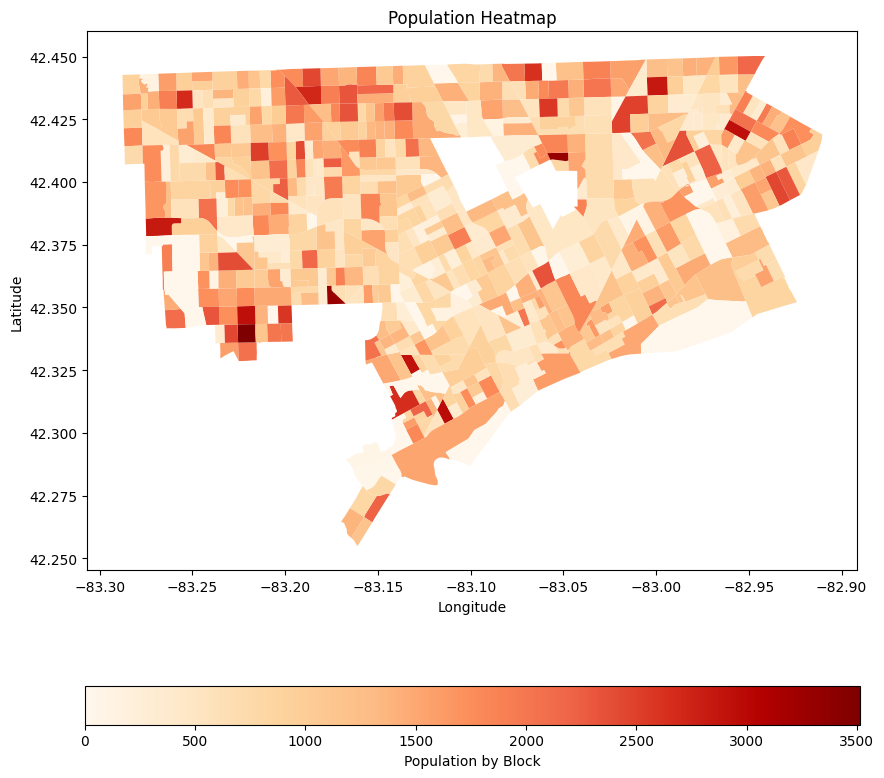

In [15]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load your shapefile
gdf = gpd.read_file("datasets/shapefiles/SimplyAnalytics_Shapefiles_2024-03-25_15_51_20_06bb5972b23ee930944d21c6a8f8c132.shp")

# Assuming 'VALUE9' contains the population data
population_column = 'VALUE9'

# Plotting the heatmap
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, column=population_column, legend=True,
         legend_kwds={'label': "Population by Block", 'orientation': "horizontal"},
         cmap='OrRd')  # 'OrRd' colormap for heatmap effect

plt.title('Population Heatmap')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [5]:
import folium
import geopandas as gpd
centroid = gdf.geometry.unary_union.centroid
latitude, longitude = centroid.y, centroid.x
m = folium.Map(location=[latitude, longitude], zoom_start=12)
for _, row in gdf.iterrows():
    tooltip_text = f"Population: {row['VALUE9']}"  # Adjust 'VALUE9' if your population column is named differently
    folium.GeoJson(
        row['geometry'],
        tooltip=tooltip_text
    ).add_to(m)

# Display the map
m


In [ ]:
import geopandas as gpd
import pandas as pd
def aggregate_blocks_to_superblocks(gdf, population_threshold):

    gdf['superblock_id'] = None
    
    gdf.sindex
    
    superblock_id = 0
    for index, block in gdf.iterrows():
        if pd.isna(block['superblock_id']):
            # Find neighbors
            neighbors = gpd.sjoin(gdf, gdf.iloc[[index]], how='inner', op='touches')
            
            total_population = block['VALUE9']
            aggregated_blocks = [index]
            
            # Loop to aggregate neighbors until reaching the threshold
            while total_population < population_threshold and not neighbors.empty:
                
                neighbor_index = neighbors.index[0]
                if neighbor_index not in aggregated_blocks:
                    aggregated_blocks.append(neighbor_index)
                    total_population += gdf.loc[neighbor_index, 'VALUE9']
                
                # Update neighbors list by finding new neighbors of the last added block
                new_neighbors = gpd.sjoin(gdf, gdf.iloc[[neighbor_index]], how='inner', op='touches')
                neighbors = pd.concat([neighbors, new_neighbors]).drop_duplicates()
                neighbors = neighbors[~neighbors.index.isin(aggregated_blocks)]
                
            # give each block an ID
            for aggr_index in aggregated_blocks:
                gdf.at[aggr_index, 'superblock_id'] = superblock_id
            
            superblock_id += 1
    
    # dissolve old blocks
    superblocks = gdf.dissolve(by='superblock_id', aggfunc='sum')
    
    return superblocks

superblocks = aggregate_blocks_to_superblocks(gdf, 10000)
superblocks

In [ ]:
superblocks